In [1]:
!nvidia-smi

Thu May 13 09:32:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   32C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import sys
sys.path.append('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import scipy
from tqdm import tqdm
import json
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize

In [4]:
def get_metrics(y_test, predicted_y):
    mse = round(mean_squared_error(y_test, predicted_y), 4)
    mae = round(mean_absolute_error(y_test, predicted_y),4)
    r = round(r2_score(y_test, predicted_y), 4)
    pearsonr_corr, pearsonr_corr_p = stats.pearsonr(y_test, predicted_y)
    spearman_corr, spearman_p = stats.spearmanr(y_test, predicted_y)
    print("Report:")
    print(f"mean_squared_error: {mse}\nmean_absolute_error: {mae}\nr2_score {r}")
    print(f"pearsonr_corr: {round(pearsonr_corr, 4)}, pearsonr_p: {round(pearsonr_corr_p, 4)}")
    print(f"spearman_corr: {round(spearman_corr, 4)}, spearman_p: {round(spearman_p, 4)}")
    print()
    return mse, mae, r, pearsonr_corr

In [5]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

base_info = get_base_data()


In [6]:
base_info

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [7]:
base_info_no_test = base_info[base_info.duplicated("vk_id_encrypted") == False]

In [8]:
base_info_no_test

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [9]:
files = glob("../../data/proc_messages-date-user2/texts/*")
files[:10]

['../../data/proc_messages-date-user2/texts/311226232.json.gz',
 '../../data/proc_messages-date-user2/texts/55106467.json.gz',
 '../../data/proc_messages-date-user2/texts/282720738.json.gz',
 '../../data/proc_messages-date-user2/texts/122949173.json.gz',
 '../../data/proc_messages-date-user2/texts/220419749.json.gz',
 '../../data/proc_messages-date-user2/texts/90175295.json.gz',
 '../../data/proc_messages-date-user2/texts/137479231.json.gz',
 '../../data/proc_messages-date-user2/texts/609145811.json.gz',
 '../../data/proc_messages-date-user2/texts/695942899.json.gz',
 '../../data/proc_messages-date-user2/texts/52851195.json.gz']

In [10]:
# prepare data: for each user get messages in interval [freud_install_time - 3 months; freud_install_time]

In [11]:
from glob import glob
path_to_messages = "../../data/proc_messages-date-user2/texts/"
all_users_with_messages = [int(os.path.basename(f).split(".")[0]) for f in glob(os.path.join(path_to_messages, "*"))]
all_users_with_messages[:10]

[311226232,
 55106467,
 282720738,
 122949173,
 220419749,
 90175295,
 137479231,
 609145811,
 695942899,
 52851195]

In [12]:
def found_data(x):
    return True if x in all_users_with_messages else False

base_info_no_test["found_messages"] = base_info_no_test.vk_id_encrypted.apply(found_data)

In [13]:
base_info_no_test[base_info_no_test["found_messages"] == True]

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,...,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,found_messages
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,...,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,True
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,...,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,True
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,...,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38,True
7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,23.0,4.0,4.0,...,1.0,1.0,24.0,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,True
10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,10.0,6.0,6.0,...,2.0,6.0,9.0,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,13.0,4.0,4.0,...,3.0,6.0,16.0,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,True
2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,22.0,2.0,5.0,...,2.0,5.0,19.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,True
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,...,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,True
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,...,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,True


In [14]:
base_info_no_test_with_messages = base_info_no_test[base_info_no_test["found_messages"] == True]

In [15]:
needed_columns = ["vk_id_encrypted", "freud_install_time", "who_score", "diener_score"]

In [16]:
for row in base_info_no_test_with_messages[needed_columns][:5].iterrows():
    print(row[1]["freud_install_time"])

2018-06-26 13:01:22
2018-07-08 08:33:11
2018-06-28 18:57:38
2018-07-17 11:38:02
2018-08-28 13:33:33


In [17]:
prepared_data  = base_info_no_test_with_messages.reset_index()[needed_columns]
prepared_data

,vk_id_encrypted,freud_install_time,who_score,diener_score
0,677093196,2018-06-26 13:01:22,16.0,19.0
1,188075273,2018-07-08 08:33:11,14.0,25.0
2,435358060,2018-06-28 18:57:38,12.0,22.0
3,518613556,2018-07-17 11:38:02,23.0,24.0
4,200269216,2018-08-28 13:33:33,10.0,9.0
...,...,...,...,...
851,540669219,2018-03-29 10:04:57,13.0,16.0
852,354174379,2018-06-30 09:03:00,22.0,19.0
853,954555625,2018-08-27 01:15:08,16.0,15.0
854,849073825,2018-03-27 08:28:00,15.0,21.0


In [18]:
by_user_dialog_number = []
by_user_message_number = []
user_texts = []
by_user_by_speakers_messages = []
choised_indicies = []
vk_ids_choised = []

for row in tqdm(prepared_data.iterrows()):
    right_boundary = parser.parse(row[1]["freud_install_time"])
    left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**{"months": 1})
    texts_filtered_by_dates = []
    messages_file_path = f"../../data/proc_messages-date-user2/texts/{row[1]['vk_id_encrypted']}.json.gz"
    with gzip.open(messages_file_path, 'r') as f_in:
        original_texts = json.load(f_in)
        messages_by_spakers = []
        for speaker_id, messages in original_texts.items():
            spaker_available_messages = []
            for message, time in messages:
                time = parser.parse(time)
                if left_boundary <= time <= right_boundary:
                    spaker_available_messages.append(message)
            if spaker_available_messages:
                messages_by_spakers.append(spaker_available_messages)
                    
        if len(messages_by_spakers) > 0:
            choised_indicies.append(row[0])
            vk_ids_choised.append(row[1]['vk_id_encrypted'])
            by_user_dialog_number.append(len(messages_by_spakers))
            by_user_message_number.append(sum([len(x) for x in messages_by_spakers]))
            by_user_by_speakers_messages.append(messages_by_spakers)
            user_texts.append([m for ms in messages_by_spakers for m in ms])

856it [23:07,  1.62s/it]


In [19]:
message_stats = pd.DataFrame(
    {"by_user_dialog_number": by_user_dialog_number, 
     "by_user_message_number": by_user_message_number,
     "by_user_by_speakers_messages": by_user_by_speakers_messages,
    "user_texts": user_texts,
     "vk_ids_choised": vk_ids_choised
    })

In [20]:
message_stats

,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,23,1754,"[[с большими усилиями и психами на гошу сдала,...","[с большими усилиями и психами на гошу сдала, ...",435358060
1,12,1261,"[[привет), нет), нее), учебный отпуск, есть ле...","[привет), нет), нее), учебный отпуск, есть лек...",518613556
2,11,121,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,8,10728,"[[Удачи, Как обычно, Как всегда обдолбанная, В...","[Удачи, Как обычно, Как всегда обдолбанная, В ...",305836538
4,6,805,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...
714,44,543,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
715,23,3853,"[[Да еб твою мать, Сколько уже можно то, Тольк...","[Да еб твою мать, Сколько уже можно то, Только...",354174379
716,9,570,"[[Венгер и ролики на Ютубе], [Спасибо тебе огр...","[Венгер и ролики на Ютубе, Спасибо тебе огромн...",954555625
717,43,8956,"[[Мою я значит твою ступку на кухне, как мне н...","[Мою я значит твою ступку на кухне, как мне на...",849073825


In [21]:
messages_with_scores = pd.concat([prepared_data.iloc[choised_indicies].reset_index(), message_stats], axis=1)

In [22]:
# with open("./messages_with_scores.json", "w") as f:
#     json.dump(messages_with_scores.to_dict(), f, ensure_ascii=False, indent=4)

In [23]:
# !head message_stats.json

In [24]:
message_stats = pd.DataFrame(messages_with_scores)
message_stats

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,23,1754,"[[с большими усилиями и психами на гошу сдала,...","[с большими усилиями и психами на гошу сдала, ...",435358060
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,12,1261,"[[привет), нет), нее), учебный отпуск, есть ле...","[привет), нет), нее), учебный отпуск, есть лек...",518613556
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,11,121,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,8,10728,"[[Удачи, Как обычно, Как всегда обдолбанная, В...","[Удачи, Как обычно, Как всегда обдолбанная, В ...",305836538
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,6,805,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...,...,...,...,...,...
714,851,540669219,2018-03-29 10:04:57,13.0,16.0,44,543,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
715,852,354174379,2018-06-30 09:03:00,22.0,19.0,23,3853,"[[Да еб твою мать, Сколько уже можно то, Тольк...","[Да еб твою мать, Сколько уже можно то, Только...",354174379
716,853,954555625,2018-08-27 01:15:08,16.0,15.0,9,570,"[[Венгер и ролики на Ютубе], [Спасибо тебе огр...","[Венгер и ролики на Ютубе, Спасибо тебе огромн...",954555625
717,854,849073825,2018-03-27 08:28:00,15.0,21.0,43,8956,"[[Мою я значит твою ступку на кухне, как мне н...","[Мою я значит твою ступку на кухне, как мне на...",849073825


<AxesSubplot:ylabel='Frequency'>

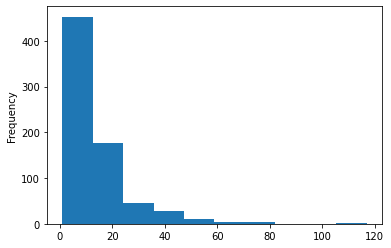

In [25]:
messages_with_scores.by_user_dialog_number.plot.hist()

<AxesSubplot:ylabel='Frequency'>

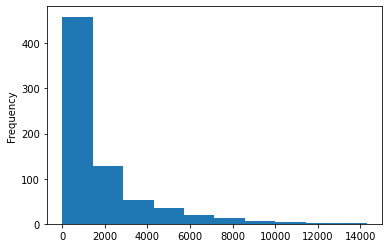

In [26]:
messages_with_scores.by_user_message_number.plot.hist()

In [27]:
messages_with_scores_many_data = messages_with_scores[messages_with_scores.by_user_message_number > 30]

In [42]:
messages_with_scores_many_data.shape

(644, 11)

In [29]:
messages_with_scores_many_data["text"] = messages_with_scores_many_data.user_texts.apply(lambda x: " ".join(x))

In [30]:
messages_with_scores_many_data

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised,text
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,23,1754,"[[с большими усилиями и психами на гошу сдала,...","[с большими усилиями и психами на гошу сдала, ...",435358060,с большими усилиями и психами на гошу сдала ос...
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,12,1261,"[[привет), нет), нее), учебный отпуск, есть ле...","[привет), нет), нее), учебный отпуск, есть лек...",518613556,"привет) нет) нее) учебный отпуск есть лекции, ..."
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,11,121,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216,"О, спасибо огромное) мне очень приятно что вы ..."
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,8,10728,"[[Удачи, Как обычно, Как всегда обдолбанная, В...","[Удачи, Как обычно, Как всегда обдолбанная, В ...",305836538,Удачи Как обычно Как всегда обдолбанная В тех ...
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,6,805,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105,"Нашивки еще не делала, но пару раз вышивала на..."
...,...,...,...,...,...,...,...,...,...,...,...
714,851,540669219,2018-03-29 10:04:57,13.0,16.0,44,543,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219,Немного 4 Я в курилке уже стою Что творишь? Ау...
715,852,354174379,2018-06-30 09:03:00,22.0,19.0,23,3853,"[[Да еб твою мать, Сколько уже можно то, Тольк...","[Да еб твою мать, Сколько уже можно то, Только...",354174379,Да еб твою мать Сколько уже можно то Только я?...
716,853,954555625,2018-08-27 01:15:08,16.0,15.0,9,570,"[[Венгер и ролики на Ютубе], [Спасибо тебе огр...","[Венгер и ролики на Ютубе, Спасибо тебе огромн...",954555625,Венгер и ролики на Ютубе Спасибо тебе огромное...
717,854,849073825,2018-03-27 08:28:00,15.0,21.0,43,8956,"[[Мою я значит твою ступку на кухне, как мне н...","[Мою я значит твою ступку на кухне, как мне на...",849073825,"Мою я значит твою ступку на кухне, как мне на ..."


In [31]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 2), 
               max_df = 0.98,
               min_df = 2,
               tokenizer = wordpunct_tokenize
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', Ridge())
])

In [32]:
import numpy as np
from sklearn.model_selection import KFold

def base_estimations(target="who_score"):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        pipe.fit(messages_with_scores_many_data.text.iloc[train], messages_with_scores_many_data[target].iloc[train])
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    for name, values in scores.items():
        print()
        print("Result")
        print(f"{name}: {sum(values)/len(values)}")

Расчет базовой метерики на простом пайплайне из тф-идф и ридж регрессии. Используется кросс-валидация на 5 фолдов.

## Who score 


Report:
mean_squared_error: 22.269
mean_absolute_error: 3.9586
r2_score 0.1053
pearsonr_corr: 0.3544, pearsonr_p: 0.0
spearman_corr: 0.4001, spearman_p: 0.0



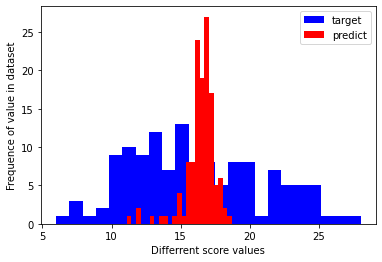

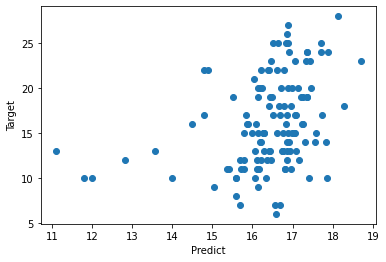

Report:
mean_squared_error: 15.9877
mean_absolute_error: 3.2556
r2_score -0.026
pearsonr_corr: 0.067, pearsonr_p: 0.4504
spearman_corr: 0.0585, spearman_p: 0.5104



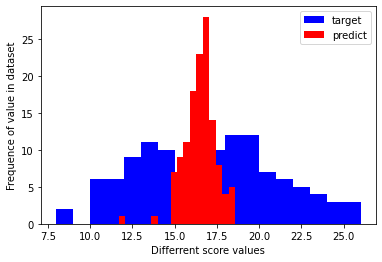

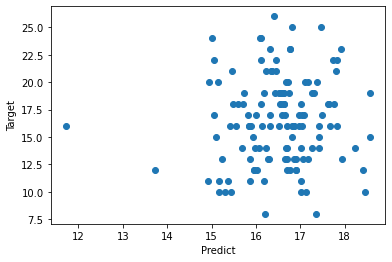

Report:
mean_squared_error: 24.3242
mean_absolute_error: 3.9782
r2_score 0.0594
pearsonr_corr: 0.2547, pearsonr_p: 0.0036
spearman_corr: 0.208, spearman_p: 0.018



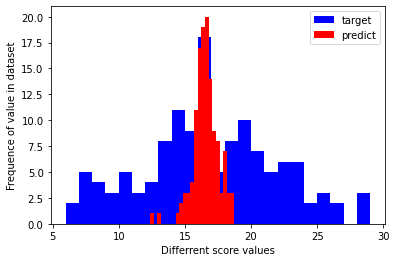

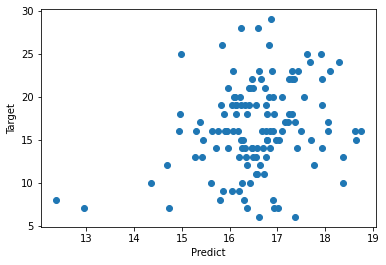

Report:
mean_squared_error: 24.7647
mean_absolute_error: 4.0702
r2_score -0.0129
pearsonr_corr: 0.0928, pearsonr_p: 0.2955
spearman_corr: 0.1073, spearman_p: 0.2262



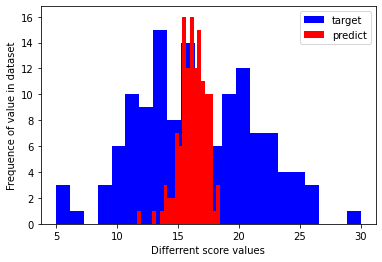

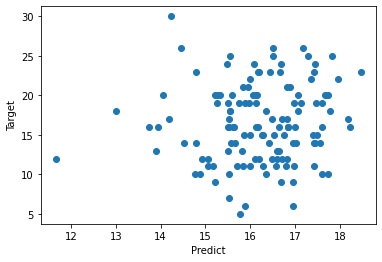

Report:
mean_squared_error: 21.2921
mean_absolute_error: 3.784
r2_score 0.0292
pearsonr_corr: 0.1785, pearsonr_p: 0.0438
spearman_corr: 0.0986, spearman_p: 0.2683



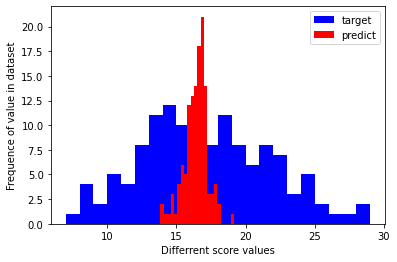

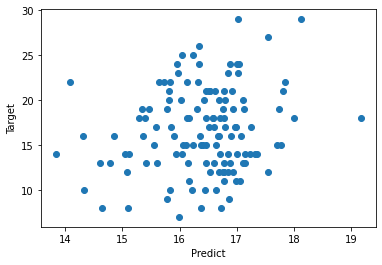


Result
mae: 21.72754

Result
mse: 3.8093199999999996

Result
r: 0.031000000000000007

Result
pearson: 0.18950303567450502


In [33]:
base_estimations()

## Diener score

Report:
mean_squared_error: 44.5775
mean_absolute_error: 5.6215
r2_score 0.044
pearsonr_corr: 0.2148, pearsonr_p: 0.0145
spearman_corr: 0.2277, spearman_p: 0.0095



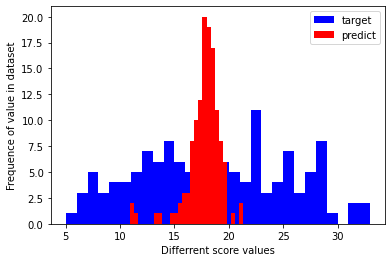

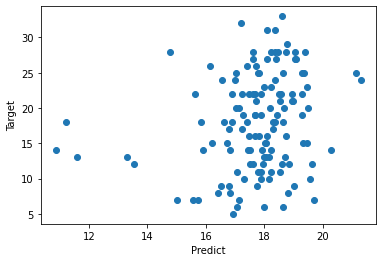

Report:
mean_squared_error: 41.4907
mean_absolute_error: 5.4119
r2_score -0.0062
pearsonr_corr: 0.1507, pearsonr_p: 0.0882
spearman_corr: 0.1624, spearman_p: 0.066



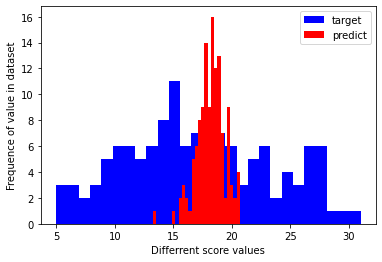

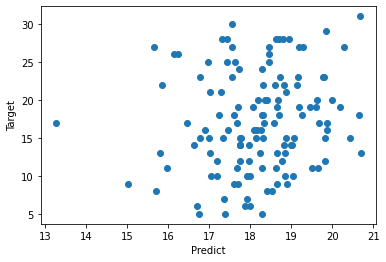

Report:
mean_squared_error: 43.6008
mean_absolute_error: 5.3478
r2_score 0.0486
pearsonr_corr: 0.2455, pearsonr_p: 0.005
spearman_corr: 0.2749, spearman_p: 0.0016



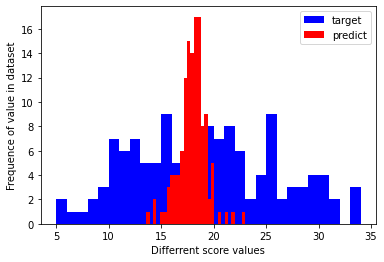

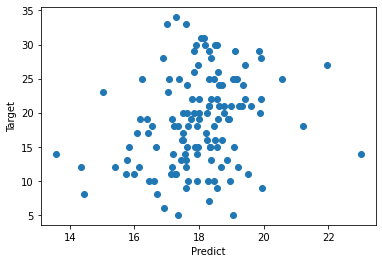

Report:
mean_squared_error: 46.1242
mean_absolute_error: 5.7064
r2_score 0.0306
pearsonr_corr: 0.179, pearsonr_p: 0.0424
spearman_corr: 0.1704, spearman_p: 0.0535



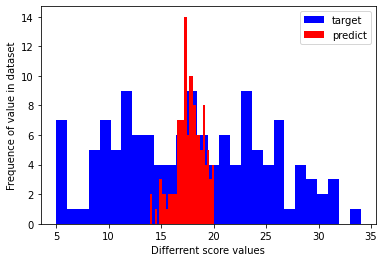

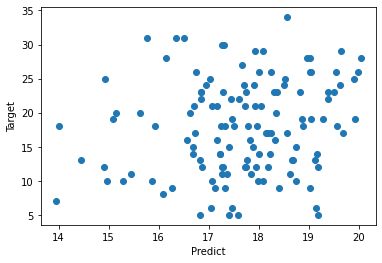

Report:
mean_squared_error: 38.1655
mean_absolute_error: 5.1501
r2_score 0.0411
pearsonr_corr: 0.2032, pearsonr_p: 0.0214
spearman_corr: 0.1727, spearman_p: 0.0513



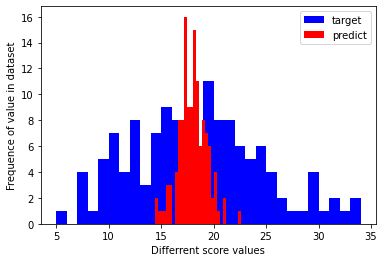

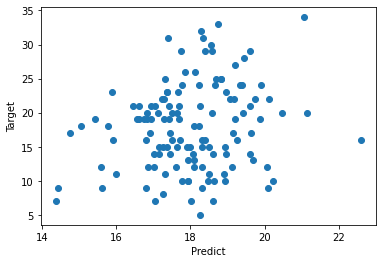


Result
mae: 42.79174

Result
mse: 5.447540000000001

Result
r: 0.03162

Result
pearson: 0.19865908291717757


In [34]:
base_estimations(target="diener_score")

In [35]:
def with_augs_estimations(target = "who_score", augs_coef = 2):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        augmented_data = {"source": [], "target": []}
        for score, texts in zip(messages_with_scores_many_data[target].iloc[train].tolist(), messages_with_scores_many_data.by_user_by_speakers_messages.iloc[train].tolist()):
            current_pos = 0
            bound = int(len(texts) / augs_coef)
            for part in range(augs_coef):
                text = " ".join([m for mes in texts[current_pos: current_pos + bound] for m in mes])
                augmented_data["source"].append(text)
                augmented_data["target"].append(score)
                current_pos += bound
        
        augmented_data = pd.DataFrame(augmented_data)        
        pipe.fit(augmented_data.source, augmented_data.target)
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    print()
    print("Result")
    for name, values in scores.items():
        print(f"{name}: {sum(values)/len(values)}")

Расчет метерики на простом пайплайне из тф-идф и ридж регрессии с аугментацией. 
Суть аугментации: сообщения каждого пользователя делятся на n равных частьей без привязки к диалогам (по дефолту 2 части). 
Так как каждая часть относится к одному и тому же пользователю, то она становится независимым тренировочным примеров с таргетом равным таргету пользователя. Таким образом выборка увеличивается в n-раз. 
Используется кросс-валидация на 5 фолдов.

## Who score

Report:
mean_squared_error: 22.5291
mean_absolute_error: 3.9657
r2_score 0.0949
pearsonr_corr: 0.3172, pearsonr_p: 0.0003
spearman_corr: 0.3281, spearman_p: 0.0001



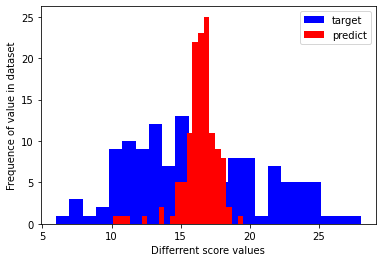

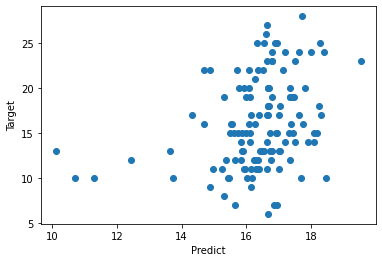

Report:
mean_squared_error: 16.2608
mean_absolute_error: 3.267
r2_score -0.0435
pearsonr_corr: 0.0673, pearsonr_p: 0.4489
spearman_corr: 0.0821, spearman_p: 0.3548



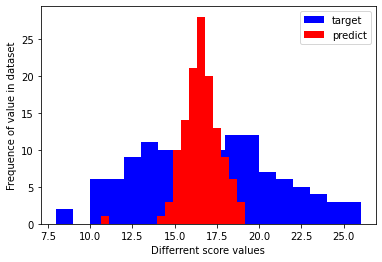

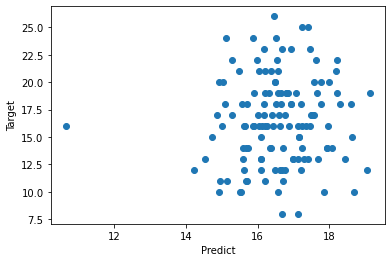

Report:
mean_squared_error: 24.0867
mean_absolute_error: 3.9469
r2_score 0.0686
pearsonr_corr: 0.2679, pearsonr_p: 0.0021
spearman_corr: 0.2511, spearman_p: 0.0041



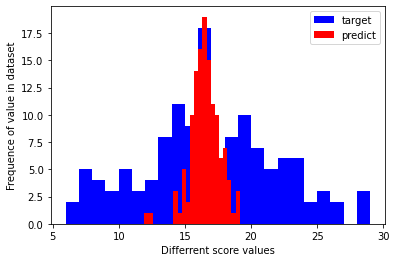

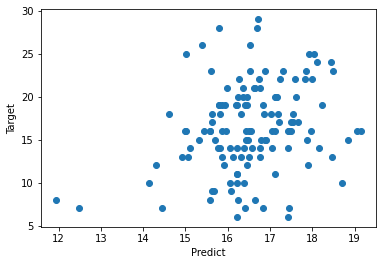

Report:
mean_squared_error: 25.0989
mean_absolute_error: 4.1255
r2_score -0.0265
pearsonr_corr: 0.0918, pearsonr_p: 0.3006
spearman_corr: 0.0966, spearman_p: 0.2764



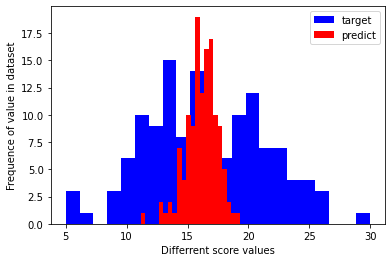

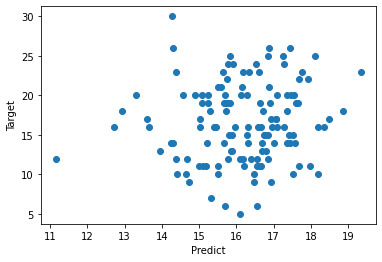

Report:
mean_squared_error: 21.7357
mean_absolute_error: 3.8118
r2_score 0.009
pearsonr_corr: 0.1438, pearsonr_p: 0.1054
spearman_corr: 0.0622, spearman_p: 0.4853



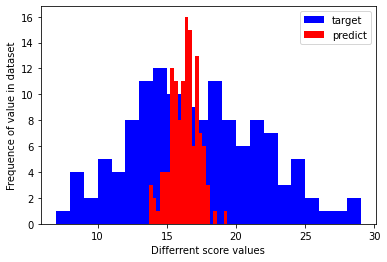

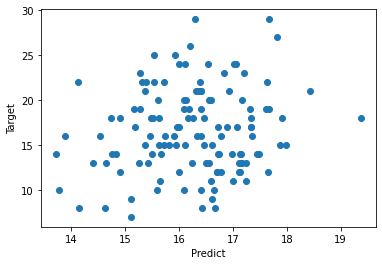


Result
mae: 21.942240000000005
mse: 3.8233800000000002
r: 0.020499999999999997
pearson: 0.17759126739412695


In [36]:
with_augs_estimations()

Report:
mean_squared_error: 22.7044
mean_absolute_error: 3.9723
r2_score 0.0878
pearsonr_corr: 0.3038, pearsonr_p: 0.0005
spearman_corr: 0.3016, spearman_p: 0.0005



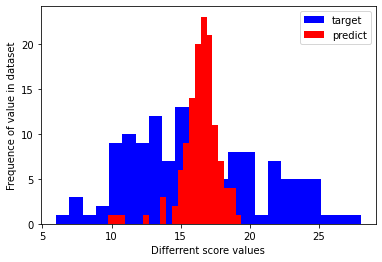

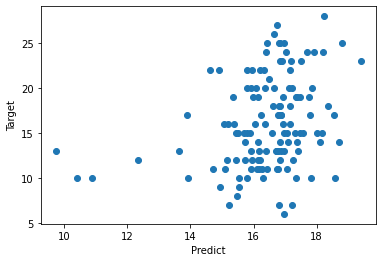

Report:
mean_squared_error: 16.8034
mean_absolute_error: 3.328
r2_score -0.0783
pearsonr_corr: 0.0281, pearsonr_p: 0.7516
spearman_corr: 0.0367, spearman_p: 0.6799



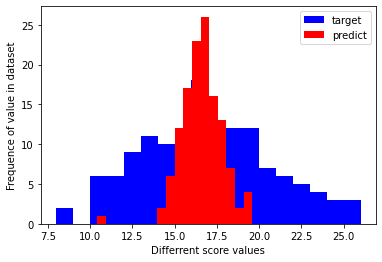

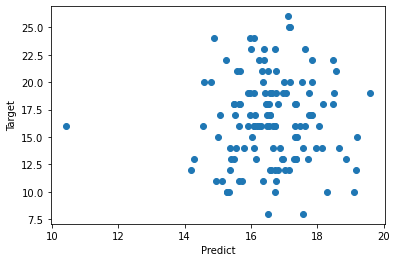

Report:
mean_squared_error: 23.7289
mean_absolute_error: 3.8944
r2_score 0.0825
pearsonr_corr: 0.2961, pearsonr_p: 0.0007
spearman_corr: 0.2711, spearman_p: 0.0019



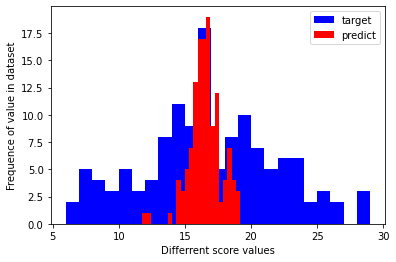

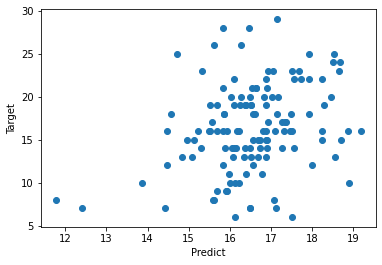

Report:
mean_squared_error: 24.6864
mean_absolute_error: 4.0874
r2_score -0.0097
pearsonr_corr: 0.1337, pearsonr_p: 0.131
spearman_corr: 0.1335, spearman_p: 0.1314



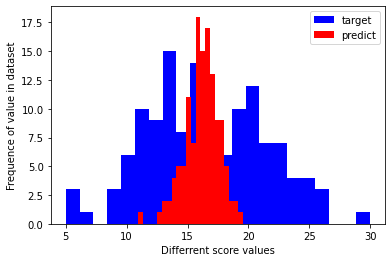

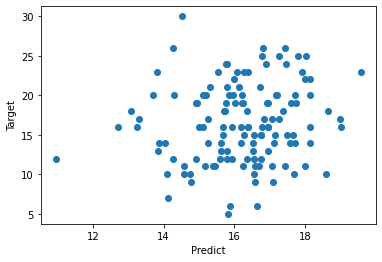

Report:
mean_squared_error: 21.4363
mean_absolute_error: 3.7879
r2_score 0.0227
pearsonr_corr: 0.1733, pearsonr_p: 0.0504
spearman_corr: 0.0883, spearman_p: 0.3217



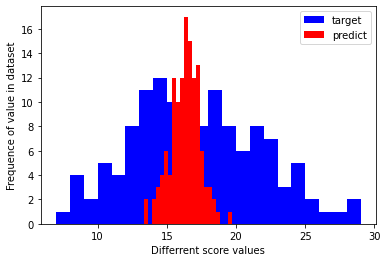

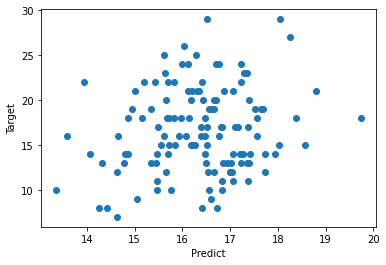


Result
mae: 21.87188
mse: 3.814
r: 0.021
pearson: 0.18700856210799538


In [37]:
with_augs_estimations(augs_coef = 3)

Report:
mean_squared_error: 22.8729
mean_absolute_error: 3.9652
r2_score 0.0811
pearsonr_corr: 0.2886, pearsonr_p: 0.0009
spearman_corr: 0.2809, spearman_p: 0.0013



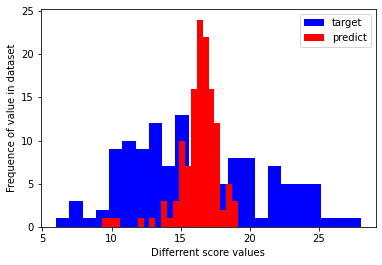

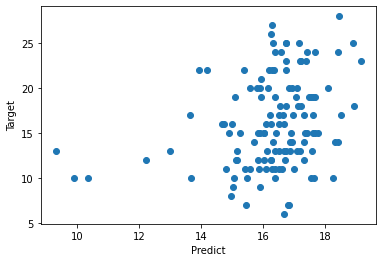

Report:
mean_squared_error: 16.8762
mean_absolute_error: 3.3266
r2_score -0.083
pearsonr_corr: 0.0499, pearsonr_p: 0.5743
spearman_corr: 0.0719, spearman_p: 0.4178



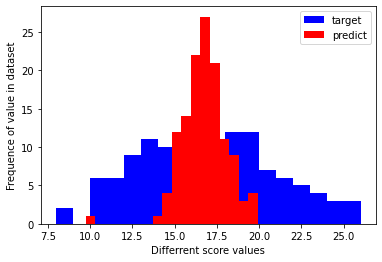

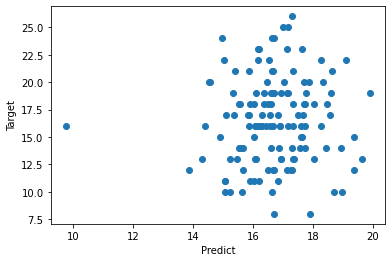

Report:
mean_squared_error: 23.8039
mean_absolute_error: 3.9355
r2_score 0.0796
pearsonr_corr: 0.288, pearsonr_p: 0.0009
spearman_corr: 0.2754, spearman_p: 0.0016



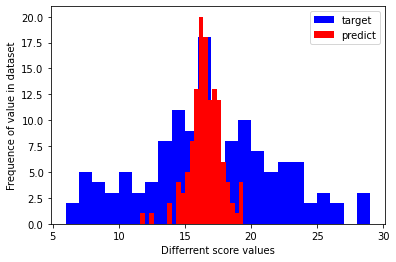

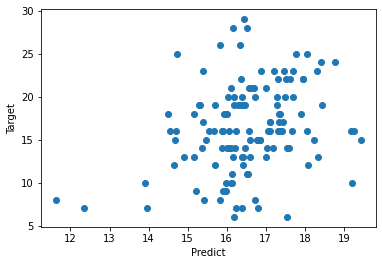

Report:
mean_squared_error: 24.7876
mean_absolute_error: 4.1051
r2_score -0.0138
pearsonr_corr: 0.1316, pearsonr_p: 0.137
spearman_corr: 0.1282, spearman_p: 0.1477



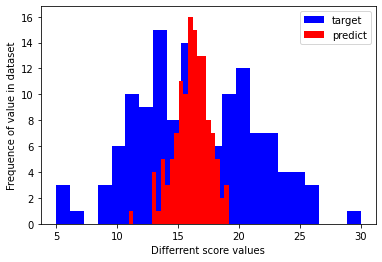

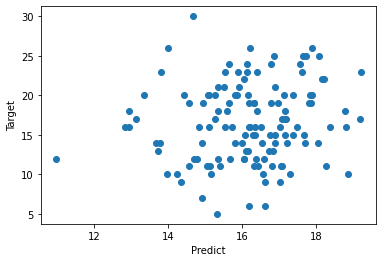

Report:
mean_squared_error: 22.1637
mean_absolute_error: 3.8468
r2_score -0.0105
pearsonr_corr: 0.1211, pearsonr_p: 0.1734
spearman_corr: 0.0449, spearman_p: 0.615



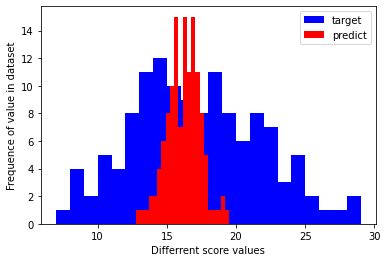

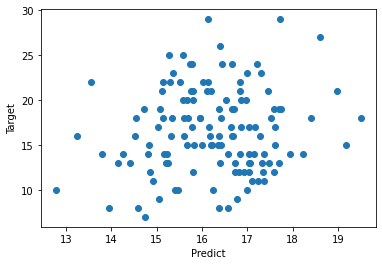


Result
mae: 22.10086
mse: 3.83584
r: 0.010680000000000002
pearson: 0.17583015824058096


In [38]:
with_augs_estimations(augs_coef = 4)

## Diener score

Report:
mean_squared_error: 45.7394
mean_absolute_error: 5.6649
r2_score 0.019
pearsonr_corr: 0.1763, pearsonr_p: 0.0457
spearman_corr: 0.1697, spearman_p: 0.0545



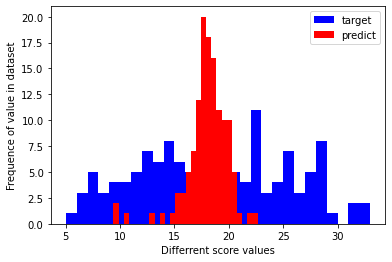

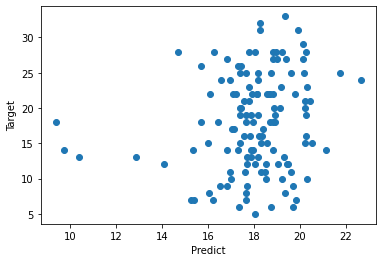

Report:
mean_squared_error: 41.6295
mean_absolute_error: 5.431
r2_score -0.0096
pearsonr_corr: 0.1472, pearsonr_p: 0.0961
spearman_corr: 0.1453, spearman_p: 0.1003



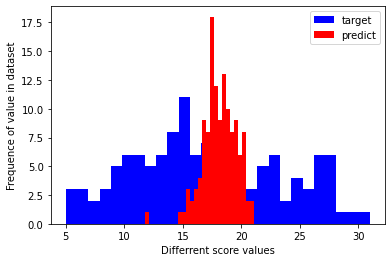

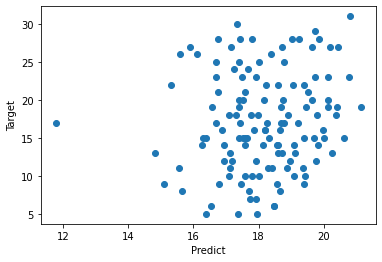

Report:
mean_squared_error: 41.9271
mean_absolute_error: 5.2237
r2_score 0.0851
pearsonr_corr: 0.3255, pearsonr_p: 0.0002
spearman_corr: 0.368, spearman_p: 0.0



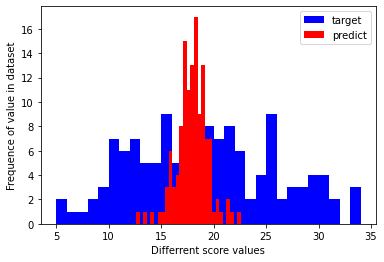

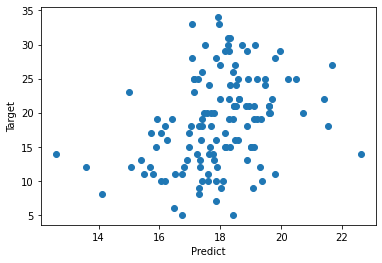

Report:
mean_squared_error: 46.4095
mean_absolute_error: 5.7074
r2_score 0.0246
pearsonr_corr: 0.1682, pearsonr_p: 0.0567
spearman_corr: 0.1469, spearman_p: 0.0967



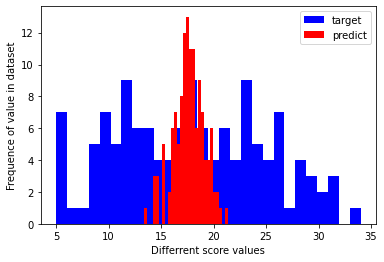

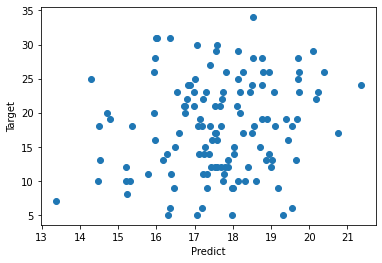

Report:
mean_squared_error: 38.2745
mean_absolute_error: 5.1903
r2_score 0.0383
pearsonr_corr: 0.2016, pearsonr_p: 0.0225
spearman_corr: 0.1405, spearman_p: 0.1138



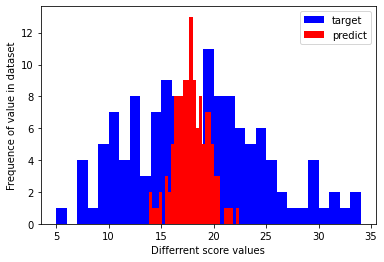

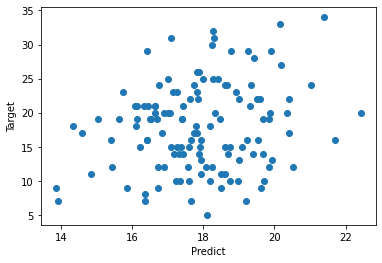


Result
mae: 42.79600000000001
mse: 5.44346
r: 0.031479999999999994
pearson: 0.2037378740860584


In [39]:
with_augs_estimations(target="diener_score")

Report:
mean_squared_error: 45.8669
mean_absolute_error: 5.6188
r2_score 0.0163
pearsonr_corr: 0.183, pearsonr_p: 0.0379
spearman_corr: 0.1897, spearman_p: 0.0313



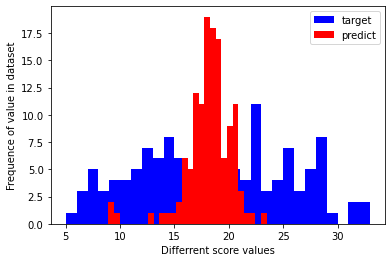

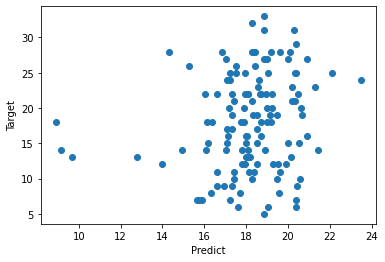

Report:
mean_squared_error: 42.8127
mean_absolute_error: 5.535
r2_score -0.0383
pearsonr_corr: 0.1131, pearsonr_p: 0.2019
spearman_corr: 0.1105, spearman_p: 0.2125



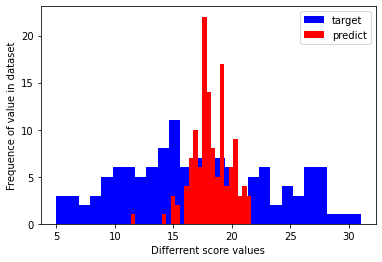

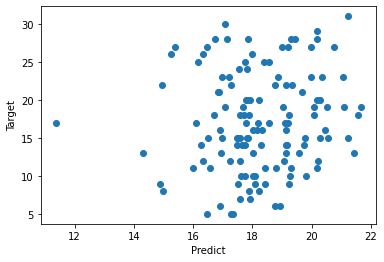

Report:
mean_squared_error: 40.9365
mean_absolute_error: 5.1265
r2_score 0.1067
pearsonr_corr: 0.358, pearsonr_p: 0.0
spearman_corr: 0.389, spearman_p: 0.0



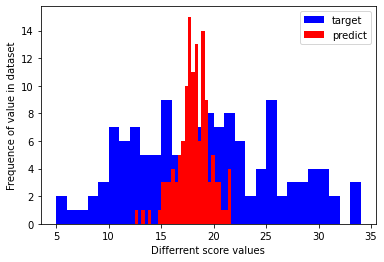

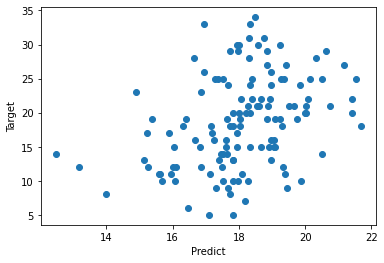

Report:
mean_squared_error: 45.7897
mean_absolute_error: 5.6892
r2_score 0.0377
pearsonr_corr: 0.2001, pearsonr_p: 0.023
spearman_corr: 0.1836, spearman_p: 0.0372



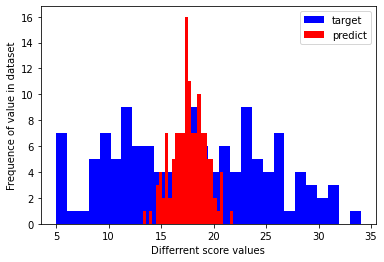

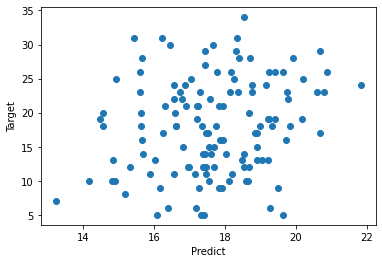

Report:
mean_squared_error: 38.2477
mean_absolute_error: 5.164
r2_score 0.039
pearsonr_corr: 0.2077, pearsonr_p: 0.0186
spearman_corr: 0.1493, spearman_p: 0.0926



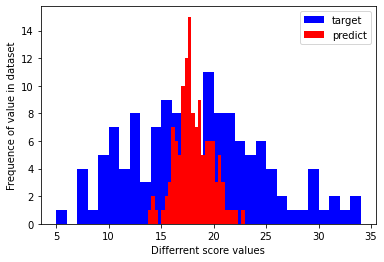

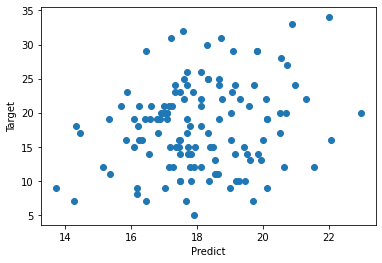


Result
mae: 42.7307
mse: 5.426699999999999
r: 0.032279999999999996
pearson: 0.212377293036306


In [40]:
with_augs_estimations(target="diener_score", augs_coef = 3)

Report:
mean_squared_error: 46.6493
mean_absolute_error: 5.709
r2_score -0.0005
pearsonr_corr: 0.1603, pearsonr_p: 0.0695
spearman_corr: 0.1766, spearman_p: 0.0453



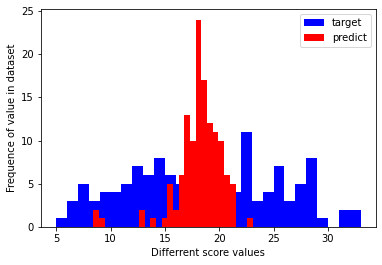

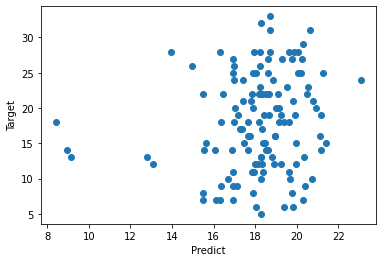

Report:
mean_squared_error: 43.383
mean_absolute_error: 5.5565
r2_score -0.0521
pearsonr_corr: 0.0811, pearsonr_p: 0.361
spearman_corr: 0.0951, spearman_p: 0.2839



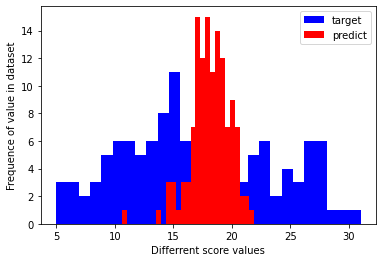

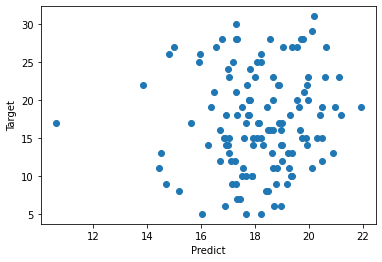

Report:
mean_squared_error: 41.6741
mean_absolute_error: 5.2228
r2_score 0.0907
pearsonr_corr: 0.3374, pearsonr_p: 0.0001
spearman_corr: 0.363, spearman_p: 0.0



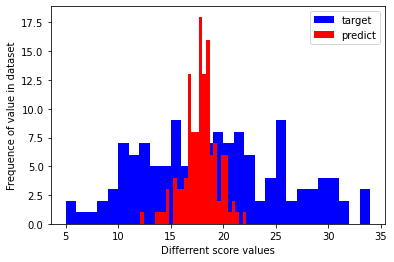

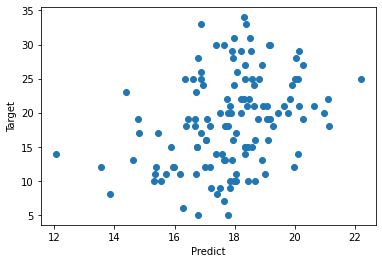

Report:
mean_squared_error: 46.4644
mean_absolute_error: 5.7238
r2_score 0.0235
pearsonr_corr: 0.172, pearsonr_p: 0.0512
spearman_corr: 0.1566, spearman_p: 0.0763



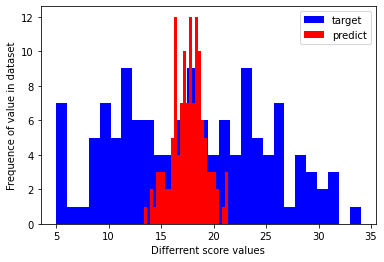

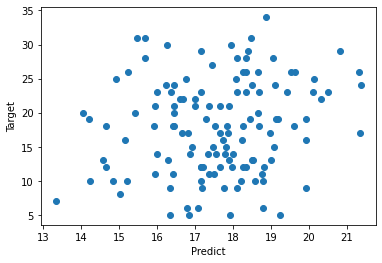

Report:
mean_squared_error: 38.2485
mean_absolute_error: 5.1841
r2_score 0.039
pearsonr_corr: 0.2071, pearsonr_p: 0.019
spearman_corr: 0.1433, spearman_p: 0.1066



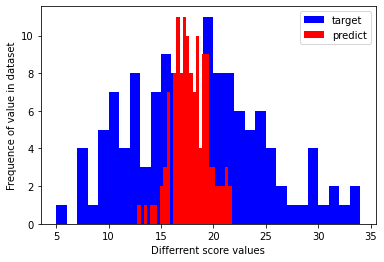

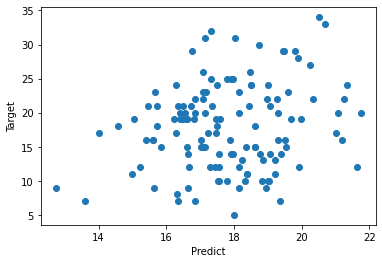


Result
mae: 43.28386
mse: 5.47924
r: 0.02012
pearson: 0.19157510798378047


In [41]:
with_augs_estimations(target="diener_score", augs_coef = 4)

# Another pipeline

In [44]:
from sklearn.neural_network import MLPRegressor

In [51]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               #max_features = 900,
               max_df = 0.98,
               min_df = 2,
               tokenizer = wordpunct_tokenize 
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', MLPRegressor(hidden_layer_sizes=512, max_iter=500, verbose=True ))
])

In [52]:
def with_augs_estimations(target = "who_score", augs_coef = 2):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        augmented_data = {"source": [], "target": []}
        for score, texts in zip(messages_with_scores_many_data[target].iloc[train].tolist(), messages_with_scores_many_data.by_user_by_speakers_messages.iloc[train].tolist()):
            current_pos = 0
            bound = int(len(texts) / augs_coef)
            for part in range(augs_coef):
                text = " ".join([m for mes in texts[current_pos: current_pos + bound] for m in mes])
                augmented_data["source"].append(text)
                augmented_data["target"].append(score)
                current_pos += bound
        
        augmented_data = pd.DataFrame(augmented_data)  
        print("augmented_data.shape: ", augmented_data.shape)
        pipe.fit(augmented_data.source, augmented_data.target)
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    print()
    print("Result")
    for name, values in scores.items():
        print(f"{name}: {sum(values)/len(values)}")

In [ ]:
with_augs_estimations(target="who_score", augs_coef = 3)

augmented_data.shape:  (1545, 2)
Iteration 1, loss = 135.40163128
Iteration 2, loss = 107.88430838
Iteration 3, loss = 80.85125146
Iteration 4, loss = 58.28316557
Iteration 5, loss = 44.88347187
Iteration 6, loss = 40.19891911
Iteration 7, loss = 38.61420625
Iteration 8, loss = 36.22364472
Iteration 9, loss = 33.60460811
Iteration 10, loss = 31.45576423
Iteration 11, loss = 29.37233294
Iteration 12, loss = 27.34590775
Iteration 13, loss = 25.37449464
Iteration 14, loss = 23.46594980
Iteration 15, loss = 21.63040360
Iteration 16, loss = 19.94501357
Iteration 17, loss = 18.35980190
Iteration 18, loss = 16.88510629
Iteration 19, loss = 15.56441300
Iteration 20, loss = 14.36395387
Iteration 21, loss = 13.35198156
Iteration 22, loss = 12.39969226
Iteration 23, loss = 11.56358501
Iteration 24, loss = 10.84217712
Iteration 25, loss = 10.20655931
Iteration 26, loss = 9.63424147
Iteration 27, loss = 9.10832625
Iteration 28, loss = 8.63042807
Iteration 29, loss = 8.20776932
Iteration 30, loss = 

In [ ]:
with_augs_estimations(target="diener_score", augs_coef = 3)